In [38]:
import yolov5
import requests
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt
import torch
torch.backends.nnpack.enabled = False

In [39]:
def download_image(image_link: str, image_name) -> str:
    response = requests.get(image_link)
    with open(image_name, "wb") as f:
        f.write(response.content)
    return image_name    

In [40]:
# set image

images = [
    'https://tablica-rejestracyjna.pl/images/photos/20241222194356.jpeg',
    "https://tablica-rejestracyjna.pl/images/photos/20241221145937.jpg" ,
    "https://tablica-rejestracyjna.pl/images/photos/20241220211840_1.jpeg",
    "https://tablica-rejestracyjna.pl/images/photos/20241226000931.png",
    'https://tablica-rejestracyjna.pl/images/photos/20241222132622.jpg',
    'https://tablica-rejestracyjna.pl/images/photos/20241223133614.jpg',
]

imagesLoaded = []
for i, image in enumerate(images):
    img_filename = download_image(image, "downloaded_image_{}.jpg".format(i))
    imagesLoaded.append(cv2.imread(img_filename))



In [41]:
# load model
model = yolov5.load('keremberke/yolov5m-license-plate')
  
# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

In [42]:

tstart = time.time()
results = []
for img in imagesLoaded:
    results.append(model(img, size=640))
    
print("inference time", time.time() - tstart)

/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


inference time 0.410869836807251


/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/jur/.local/lib/python3.12/site-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


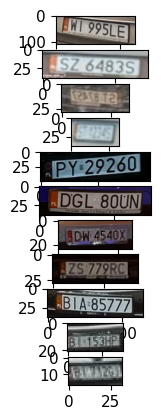

In [43]:
skewed_plates = []

for image, res in zip(imagesLoaded, results):
    predictions = res.pred[0]
    boxes = predictions[:, :4] # x1, y1, x2, y2
    scores = predictions[:, 4]
    categories = predictions[:, 5]

    for i, box in enumerate(boxes):
        box = [int(x) for x in box]
        x1, y1, x2, y2 = box
        #print(x1, y1, x2, y2)
        if(x1 > x2):
            x2, x1 = x1, x2
        if(y1 > y2):
            y2, y1 = y1, y2

        w = x2 - x1 
        h = y2 - y1 
        dw = int(0.1 * w)
        dh = int(0.1 * h)


        x2 += dw 
        x1 -= dw

        y2 += dh
        y1 -= dh


        reg = image[y1:y2, x1:x2]

        #kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
        #reg = cv2.filter2D(reg, -1, kernel) 
        

        skewed_plates.append(reg.copy())


#boxes = np.matrix(boxes)



fig, axs = plt.subplots(len(skewed_plates))
for i, reg in enumerate(skewed_plates):
    #print(reg)
    axs[i].imshow(reg)

plt.show()




11


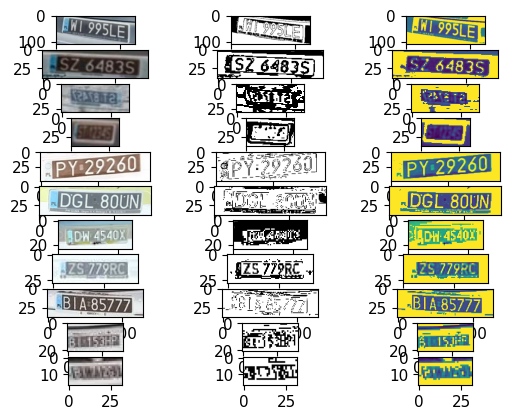

In [101]:

fig, axs = plt.subplots(len(skewed_plates), 3)
print(len(skewed_plates))

enchanced = []

for i, plate in enumerate(skewed_plates):
    plate = plate.copy()
    #plate = cv2.GaussianBlur(plate,(5,5),0)
    hsv_image = cv2.cvtColor(plate, cv2.COLOR_BGR2HSV)
    center = cv2.mean(plate)[0]
    d = 30
    low = center - d
    high = center + d   
    
    
    mask = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    mask = cv2.inRange(mask, low, high)
    mask = cv2.bitwise_not(mask)
    plate = cv2.bitwise_not(plate)
    #output = cv2.bitwise_or(plate, plate, mask = mask)
    
    # make output be binary version of plate
    output = np.zeros_like(plate)
    output = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    output[output > (255-center)] = 255



    enchanced.append(output)

    axs[i, 0].imshow(plate)
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 2].imshow(output)

11


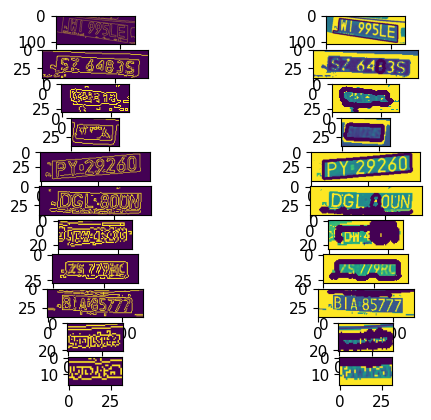

In [82]:

fig, axs = plt.subplots(len(skewed_plates), 2)
print(len(skewed_plates))
for i, plate in enumerate(enchanced):
    
    gray = plate.copy() # cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    

    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150)
    axs[i, 0].imshow(edges)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and pick the largest plausible one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    result = plate.copy()
    
    for j, contour in enumerate(contours):
        cv2.drawContours(result, [contour], -1, (0, 255, 0), 3)
        axs[i, j+1].imshow(result)
        # Approximate the contour to find a quadrilateral
        epsilon = 1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  # Check if it's a quadrilateral
            license_plate_contour = approx
            break
            
            
        if(not j < 0):
            break

    #if license_plate_contour is not None:
    #    # Draw the contour for visualization
    #    result = plate.copy()
    #    cv2.drawContours(result, [license_plate_contour], -1, (0, 255, 0), 3)
    #    axs[i].imshow(result)
    #    #cv2.imshow("Detected License Plate", result)

    #_, contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #ret, thresh = cv2.threshold(gray, center+20, 255, 0)
    #thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    


In [143]:

fig, axs = plt.subplots(len(skewed_plates), 3)
print(len(skewed_plates))
lsd = cv2.createLineSegmentDetector()
plt.rcParams["figure.figsize"] = (120, 120)

rots = []


for i, plate in enumerate(skewed_plates):
    
    gray = plate.copy() # cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 220, 255)
    
    lines = lsd.detect(edges)[0]
    #print(lines)
    if lines is not None:
        # draw image with lines of random colors
        drawn_image = np.copy(plate)
        print(plate.shape)
        limitHorizontal = 0.5 * plate.shape[1]
        limitVertical = 0.5 * plate.shape[0]

        lengthsAndAngles = []
        for j, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            angle = np.arctan2(y2 - y1, x2 - x1)
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            color = tuple(np.random.randint(0, 255, 3).tolist())
            if length > limitHorizontal:
                lengthsAndAngles.append((length, angle))
                cv2.line(drawn_image, (x1, y1), (x2, y2), color, 2)
            elif length > limitVertical:
                lengthsAndAngles.append((length, angle))
                cv2.line(drawn_image, (x1, y1), (x2, y2), [255 - x for x in color], 2)

        #drawn_image = lsd.drawSegments(np.copy(plate), lines)
        
        
        
        print(lengthsAndAngles)

    else:
        drawn_image = np.copy(image)
        rots.append(0) # no rotation


    axs[i, 0].imshow(plate)
    axs[i, 1].imshow(edges)
    axs[i, 2].imshow(drawn_image)
    
        


11
(110, 306, 3)
[(63.7869541960399, -1.5510335), (222.95052860664194, 0.119463556), (141.60346000354528, 0.14964305), (99.38873902582765, 0.11396252), (90.55383241795518, -3.0315588), (224.04271188697317, -3.0222783), (57.98648100599751, 1.6959958), (72.13218627180612, 0.15285233), (129.05663377490578, -2.992192), (121.86415134034277, -3.0604742), (69.03339704128503, 0.088804685), (78.99672747906844, 0.0744143), (65.29768783696404, -3.053757), (55.12758015667525, -3.0754662), (60.03741651598529, 1.5903528), (58.793703021350275, -1.5462142), (59.995033607461096, 1.5836594)]
(39, 145, 3)
[(27.519118500879813, -3.12213), (81.45657590452232, -3.0934775), (25.02997899368818, 0.03995174), (142.68974389549984, -3.0992494), (78.89969956271507, 0.048405886), (28.77445273873917, 0.029727036), (41.28413441200396, 0.015684415), (87.58010982434487, 0.040686715), (45.1384624753357, 0.05528298)]
(29, 69, 3)
[(25.124679737398672, -3.0411026), (15.045609298032472, 0.054012116)]
(38, 65, 3)
[(36.421718

11


/tmp/ipykernel_32457/1235067125.py:8: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)  # Convert to integer


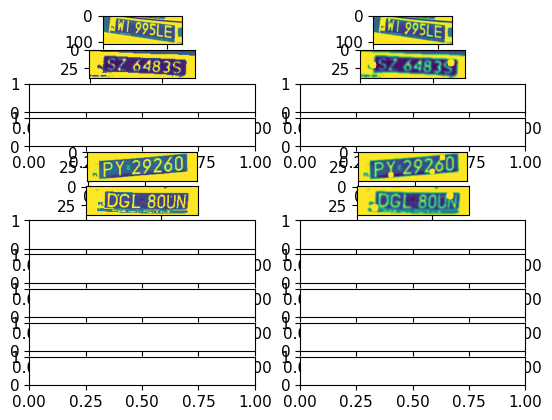

In [102]:

fig, axs = plt.subplots(len(skewed_plates), 2)
print(len(skewed_plates))
for i, plate in enumerate(enchanced):
    
    gray = plate.copy() # cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    corners = cv2.goodFeaturesToTrack(blurred, maxCorners=4, qualityLevel=0.01, minDistance=30)
    corners = np.int0(corners)  # Convert to integer
    
    if corners is None or len(corners) < 4:
        continue
    
    rect = np.zeros((4, 2), dtype="float32")
    corners = corners.reshape(-1, 2)
    s = corners.sum(axis=1)
    diff = np.diff(corners, axis=1)
    
    rect[0] = corners[np.argmin(s)]  # Top-left
    rect[2] = corners[np.argmax(s)]  # Bottom-right
    rect[1] = corners[np.argmin(diff)]  # Top-right
    rect[3] = corners[np.argmax(diff)]  # Bottom-left

    # draw rect on plate
    for j in range(4):
        pos = (int(rect[j][0]), int(rect[j][1]))
        blurred = cv2.circle(blurred, pos, 5, (255, 0, 0), -1)
    axs[i, 0].imshow(plate)
    axs[i, 1].imshow(blurred)

    



Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


['N', '995LE']
Recognized Text: N 995LE
['64835']
Recognized Text: 64835
[]
Recognized Text: 
[]
Recognized Text: 
['PY29260']
Recognized Text: PY29260
['DGL 8UN']
Recognized Text: DGL 8UN
['DH 454021']
Recognized Text: DH 454021
['09779r0']
Recognized Text: 09779r0
['"BIA 85777']
Recognized Text: "BIA 85777
[]
Recognized Text: 
[]
Recognized Text: 


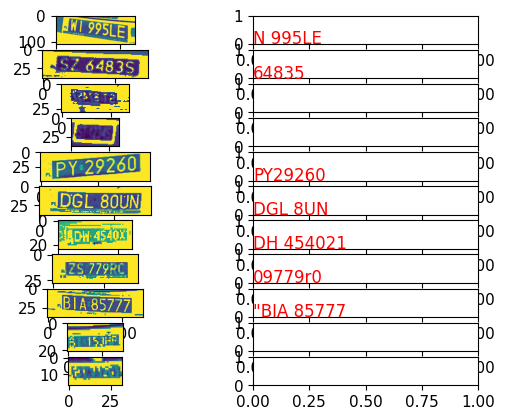

In [103]:
import easyocr
fig, axs = plt.subplots(len(enchanced), 2)
reader = easyocr.Reader(['en'])
for i, plate in enumerate(enchanced):
    plate = plate.copy()
    #plate = cv2.GaussianBlur(plate,(7,7),0)
    ocr_result = reader.readtext(plate, detail=0)
    print(ocr_result)
    print("Recognized Text:", ' '.join(ocr_result))
    axs[i, 0].imshow(plate)
    axs[i, 1].text(0, 0, ' '.join(ocr_result), fontsize=12, color='red')   

In [13]:
import pytesseract # this is tesseract module 
import matplotlib.pyplot as plt 
import cv2 # this is opencv module 
import glob 
import os

In [17]:
for plate in skewed_plates:

    predicted_result = pytesseract.image_to_string(plate, lang ='eng')#, 
    #config ='--oem 3 --psm 6 -c tessedit_char_whitelist = ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789') 
      
    
    print(predicted_result)





2D —S é
> |ADW:4540X,

;

